## ILB

In [1]:
import numpy as np
import random #pseudorandom
import csv
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import distance
import math

###Functions

In [2]:
def load_data(filename, x_col, y_col, z_col):
    x = []
    y = []
    z = []

    with open(filename, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)  # Skip the header row if present
        for row in csvreader:
            x.append(float(row[x_col]))
            y.append(float(row[y_col]))
            z.append(float(row[z_col]))

    return np.array(x), np.array(y), np.array(z)

In [3]:
def calculate_z(x, y, z, x_query, y_query):
    points = np.column_stack((x, y))
    values = z
    z_query = griddata(points, values, (x_query, y_query), method='nearest')
    return z_query

In [4]:
def calculate_distance(Zup, Zdown):
    distance = np.sqrt((Zup - Zdown) ** 2)
    return distance

In [5]:
def get_x_distance(x, y):
  min_distances = []
  i = 20
  point1 = (x[i], y[i])  # Coordinates of the current point
  min_distance = float("inf")  # Initialize with a large value
  for j in range(len(np.unique(x))):
      if i != j:  # Skip the current point
          point2 = (x[j], y[i])  # Coordinates of another point # Keep y change x
          dist = distance.euclidean(point1, point2)
          if dist > 0:
            min_distance = min(min_distance, dist)
      if min_distance > 0 or min_distance < float('inf'):
        min_distances.append(min_distance)

  # Put away zeros
  if np.unique(min_distances)[0] == 0.0:
    min_d = np.unique(min_distances)[1]
  else:
    min_d = np.unique(min_distances)[0]
  scientific_notation="{:.0e}".format(min_d)
  x_dist = float(scientific_notation)
  return x_dist

In [6]:
def get_y_distance(x, y):
  min_distances = []
  i = 20
  point1 = (x[i], y[i])  # Coordinates of the current point
  min_distance = float("inf")  # Initialize with a large value
  for j in range(len(np.unique(y))):
      if i != j:  # Skip the current point
          point2 = (x[i], y[j])  # Coordinates of another point # Keep x change y
          dist = distance.euclidean(point1, point2)
          if dist > 0:
            min_distance = min(min_distance, dist)
      if min_distance > 0 or min_distance < float('inf'):
        min_distances.append(min_distance)
  # Put away zeros
  if np.unique(min_distances)[0] == 0.0:
    min_d = np.unique(min_distances)[1]
  else:
    min_d = np.unique(min_distances)[0]
  scientific_notation="{:.0e}".format(min_d)
  y_dist = float(scientific_notation)
  return y_dist

### Main

In [ ]:
from google.colab import drive
drive.mount('/content/drive')#, force_remount=True)

Mounted at /content/drive


In [10]:
def ilb_params():
  filename_up = "ILB_4_15_A.csv"
  filename_down = "ILB_4_15_B.csv"
  x_col = 1
  y_col = 3
  z_col = 2
  return x_col, y_col, z_col, filename_up, filename_down

In [11]:
sample = "ILB_4_15"

if sample == "ILB_4_15":
  x_col, y_col, z_col, filename_up, filename_down = ilb_params()

In [12]:
upper_wall = filename_up
lower_wall = filename_down

xup, yup, zup = load_data(upper_wall, x_col, y_col, z_col)
xlow, ylow, zlow = load_data(lower_wall, x_col, y_col, z_col)

xmin = min(np.min(xup),np.min(xlow))
xmax = max(np.max(xup),np.max(xlow))
ymin = min(np.min(yup),np.min(ylow))
ymax = max(np.max(yup),np.max(ylow))

TypeError: ignored

In [ ]:
xup_dist = get_x_distance(xup, yup)
xlow_dist = get_x_distance(xlow, ylow)
yup_dist = get_y_distance(xup, yup)
ylow_dist = get_y_distance(xlow, ylow)

In [ ]:
x_dist = min(xup_dist,xlow_dist)
y_dist = min(yup_dist,ylow_dist)
x_steps = int(round((xmax-xmin)/x_dist))
y_steps = int(round((ymax-ymin)/y_dist))

In [ ]:
x = np.linspace(xmin, xmax, x_steps)
y = np.linspace(ymin, ymax, y_steps)
X,Y = np.meshgrid(x,y)

In [ ]:
Zup = calculate_z(xup,yup,zup, X, Y)
Zdown = calculate_z(xlow,ylow,zlow, X, Y)

In [ ]:
aperture = calculate_distance(Zup, Zdown)
np.savetxt('aperture_Indiana_' + sample + '.txt', np.column_stack((X.ravel(), Y.ravel(), aperture.ravel())), fmt="%.8e", delimiter=",")

In [ ]:
import seaborn as sns
import pandas as pd

In [ ]:
def plot_aperture_heatmap(X, Y, aperture):
    plt.figure(figsize=(10, 8))
    plt.imshow(aperture, extent=[X.min(), X.max(), Y.min(), Y.max()], origin='lower', cmap='viridis')#, vmin=0.0, vmax=1)
    plt.colorbar(label='Aperture (mm)',location='bottom',shrink=0.3,format="%4.3g")
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    #plt.title('Aperture (mm)')
    #plt.savefig(output_folder + filename + '.png', dpi=300)
    plt.show()

<Axes: xlabel='Aperture(m)', ylabel='Count'>

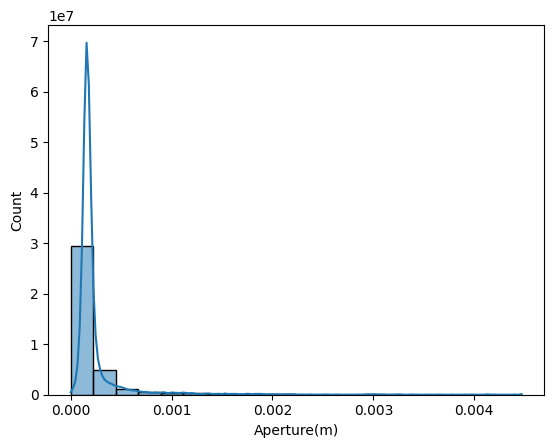

In [ ]:
sns.histplot(data=pd.DataFrame(np.ravel(aperture),columns=["Aperture(m)"]),x="Aperture(m)",bins=20,kde=True)

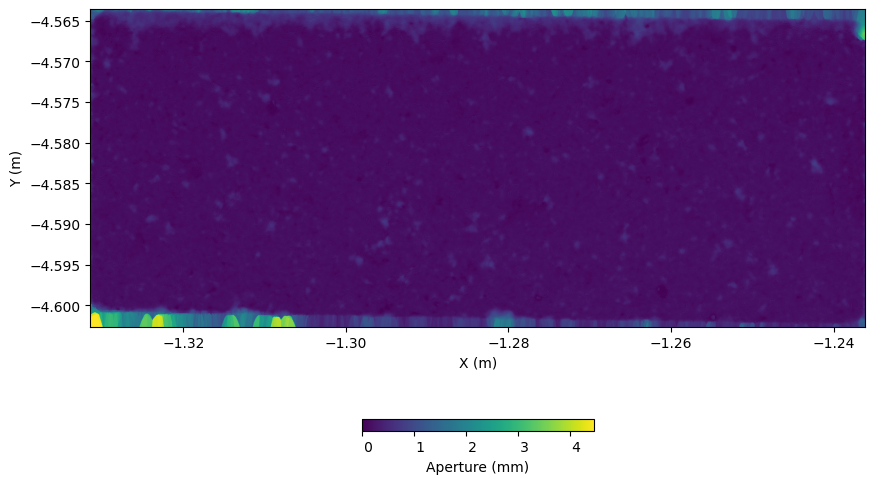

In [ ]:
plot_aperture_heatmap(X, Y, aperture*1000)

In [ ]:
print(xmin,xmax)

-1.33142 -1.23609


In [ ]:
print(ymin,ymax)

-4.60265 -4.56358


In [ ]:
print(xmax-xmin,ymax-ymin)

NameError: ignored

In [ ]:
print(xup_dist,xlow_dist,yup_dist,ylow_dist)

NameError: ignored

In [ ]:
print(round(x_steps),round(y_steps))

9546 3912
